# Поиск изображений по запросу

Разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from typing import List, Tuple, Dict, Any

import os
import requests
import zipfile
from tqdm import tqdm
import io
import re

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import ast
from PIL import Image

from transformers import BertTokenizer, BertModel
from functools import lru_cache

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import GroupShuffleSplit

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, RocCurveDisplay
from tensorflow.keras.callbacks import EarlyStopping
import textwrap

In [ ]:
url = "https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip"
response = requests.get(url)
path_01 = 'to_upload/'

In [ ]:
project_path = '/content/drive/MyDrive/Colab Notebooks/Yandex_DS/Project_search_by_pic/'

### Краудфандинговая оценка

In [ ]:
# with zipfile.ZipFile(io.BytesIO(response.content)) as crowd_file:
#     with crowd_file.open(path_01 + 'CrowdAnnotations.tsv') as file:
#         crowd_df = pd.read_csv(file, sep='\t')

In [ ]:
crowd_df = pd.read_csv(project_path + 'CrowdAnnotations.tsv', sep='\t')

In [ ]:
crowd_df.sample(5)

1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2    1  3  0
21793  2968182121_b3b491df85.jpg  2311690895_0d6efe11c8.jpg#2  0.0  0  3
30292  3290105461_7590f23371.jpg   461505235_590102a5bf.jpg#2  0.0  0  3
6660   2160266952_a2ab39191b.jpg  1490670858_e122df2560.jpg#2  0.0  0  3
44449   500446858_125702b296.jpg  2822290399_97c809d43b.jpg#2  0.0  0  3
34223  3457045393_2bbbb4e941.jpg  2991994415_504d1c0a03.jpg#2  0.0  0  3

In [ ]:
col = ['file_name', 'description', 'share_match', 'amount_match', 'amount_non_match']
crowd_df.columns = col

In [ ]:
crowd_df.sample(1)

file_name                  description  share_match  \
35695  3502993968_4ee36afb0e.jpg  3609032038_005c789f64.jpg#2          0.0   

       amount_match  amount_non_match  
35695             0                 3

In [ ]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         47829 non-null  object 
 1   description       47829 non-null  object 
 2   share_match       47829 non-null  float64
 3   amount_match      47829 non-null  int64  
 4   amount_non_match  47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


оперделим границу подтверждения соответсвия для краудсорсинговой оценки

In [ ]:
plt.hist(crowd_df[crowd_df['share_match'] > 0]['share_match'], bins=100)
plt.xlabel("Доля людей, подтвердивших соответствие")
plt.ylabel("Количество описаний")
plt.title("Распределение доли подтверждений соответствия [без 0%]")
plt.xticks(np.arange(0, 1.1, 0.05), rotation=90)
plt.show()

In [ ]:
THRESHOLD = 0.65
crowd_df['crowd_match'] = (crowd_df['share_match'] >= THRESHOLD).astype(int)

In [ ]:
crowd_df['crowd_match'].value_counts().plot.bar(color=['red', 'green'], rot=0)
plt.xlabel("0 = несоответствие, 1 = соответствие")
plt.ylabel("Количество")
plt.title("Краудфандинговое распределение соответствия изображений и текстов")
plt.show()

### Экспертная оценка

In [ ]:
# with zipfile.ZipFile(io.BytesIO(response.content)) as expert_file:
#     with expert_file.open(path_01 + 'ExpertAnnotations.tsv') as expert_file:
#         expert_df = pd.read_csv(expert_file, sep='\t')

In [ ]:
expert_df = pd.read_csv(project_path + 'ExpertAnnotations.tsv', sep='\t')

In [ ]:
expert_df.sample(5)

1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1.1  1.2
1976  2662845514_8620aaee96.jpg  2021613437_d99731f986.jpg#2  1    1    1
2261  2831217847_555b2f95ca.jpg  1554713437_61b64527dd.jpg#2  1    1    2
750   2086513494_dbbcb583e7.jpg  3425835357_204e620a66.jpg#2  1    1    1
4725  3605061440_1d08c80a57.jpg   229862312_1a0ba19dab.jpg#2  1    2    2
3798  3334537556_a2cf4e9b9a.jpg  1311388430_4ab0cd1a1f.jpg#2  1    1    2

In [ ]:
col = ['file_name', 'description', 'exp_1', 'exp_2', 'exp_3']
expert_df.columns = col

In [ ]:
expert_df.sample(1)

file_name                  description  exp_1  exp_2  \
3270  3186412658_2ab2ebd397.jpg  3556598205_86c180769d.jpg#2      1      1   

      exp_3  
3270      1

In [ ]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   file_name    5821 non-null   object
 1   description  5821 non-null   object
 2   exp_1        5821 non-null   int64 
 3   exp_2        5821 non-null   int64 
 4   exp_3        5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


агрегируем оценку экспертов

In [ ]:
def aggregate_scores(row):
    scores = [row['exp_1'], row['exp_2'], row['exp_3']]
    for score in scores:
        if scores.count(score) >= 2:
            return score
    return sorted(scores)[1]

In [ ]:
expert_df['final_score'] = expert_df.apply(aggregate_scores, axis=1)

In [ ]:
expert_df.final_score.value_counts().plot.bar(rot=0)
plt.xlabel("Оценки")
plt.ylabel("Количество")
plt.title("Экспертное распределение оценок соответствия изображений и текстов")
plt.show()

добавляем колонку match: если финальная оценка 3 или 4, то значение в этой колонке 1, если меньше, то 0

In [ ]:
expert_df['expert_match'] = expert_df['final_score'].apply(lambda x: 1 if x >= 3 else 0)

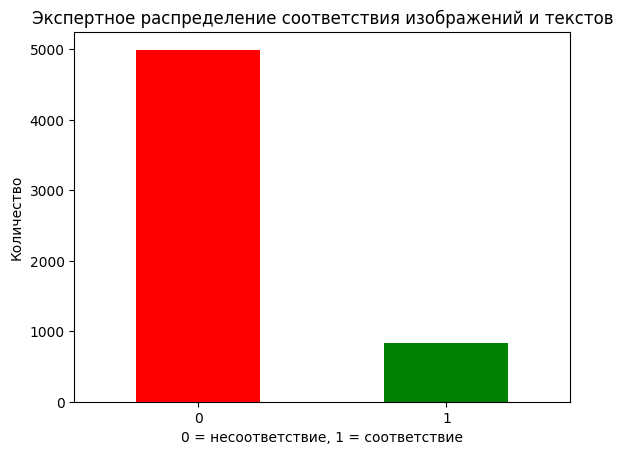

In [ ]:
expert_df.expert_match.value_counts().plot.bar(color=['red', 'green'], rot=0)
plt.xlabel("0 = несоответствие, 1 = соответствие")
plt.ylabel("Количество")
plt.title("Экспертное распределение соответствия изображений и текстов")
plt.show()

In [ ]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     5821 non-null   object
 1   description   5821 non-null   object
 2   exp_1         5821 non-null   int64 
 3   exp_2         5821 non-null   int64 
 4   exp_3         5821 non-null   int64 
 5   final_score   5821 non-null   int64 
 6   expert_match  5821 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 318.5+ KB


объединяем экспертов и краудфандинг

In [ ]:
crowd_df.shape, expert_df.shape

((47829, 6), (5821, 7))

In [ ]:
merged_df = pd.merge(
    crowd_df,
    expert_df,
    on=['file_name', 'description'],
    how='outer'
)
merged_df.shape

(51322, 11)

In [ ]:
merged_df.drop(columns=['share_match', 'amount_match',
       'amount_non_match', 'exp_1', 'exp_2', 'exp_3',
       'final_score'], axis=1, inplace=True)

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51322 entries, 0 to 51321
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_name     51322 non-null  object 
 1   description   51322 non-null  object 
 2   crowd_match   47829 non-null  float64
 3   expert_match  5821 non-null   float64
dtypes: float64(2), object(2)
memory usage: 1.6+ MB


In [ ]:
merged_df.head()

file_name                  description  crowd_match  \
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2          0.0   

   expert_match  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN

создадим финальную оценку файла с приоритетом экспертной оценки

In [ ]:
merged_df['final_match'] = merged_df['crowd_match']
mask = ~merged_df['expert_match'].isna()
merged_df.loc[mask, 'final_match'] = merged_df.loc[mask, 'expert_match']


In [ ]:
(merged_df.loc[mask, 'crowd_match'] != merged_df.loc[mask, 'expert_match']).sum()

np.int64(3878)

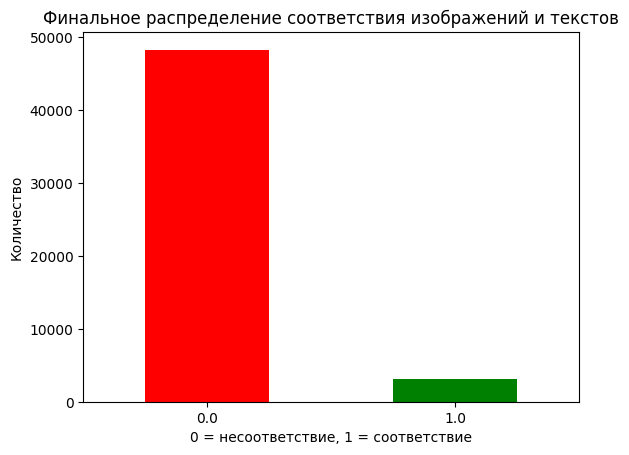

In [ ]:
merged_df.final_match.value_counts().plot.bar(color=['red', 'green'], rot=0)
plt.xlabel("0 = несоответствие, 1 = соответствие")
plt.ylabel("Количество")
plt.title("Финальное распределение соответствия изображений и текстов")
plt.show()

In [ ]:
# merged_df.duplicated(subset=['file_name', 'description'], keep=False).sum()

In [ ]:
merged_df.drop(columns=['crowd_match', 'expert_match'], axis=1, inplace=True)

In [ ]:
merged_df.shape

(51322, 3)

In [ ]:
merged_df.head()

file_name                  description  final_match
0  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0
1  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2          0.0

### Train_data изображение - описание

In [ ]:
# with zipfile.ZipFile(io.BytesIO(response.content)) as train_dataset_file:
#     with train_dataset_file.open(path_01 + 'train_dataset.csv') as train_dataset_file:
#             train_dataset_df = pd.read_csv(train_dataset_file)

In [ ]:
train_dataset_df = pd.read_csv(project_path + 'train_dataset.csv')

In [ ]:
train_dataset_df.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
train_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


~объединим сеты train_dataset_df и merged_df~
добавим в merged_df описание по колонке description

In [ ]:
merged_df = merged_df.rename(columns={'description': 'query_id'})

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51322 entries, 0 to 51321
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    51322 non-null  object 
 1   query_id     51322 non-null  object 
 2   final_match  51322 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


создадим датасет с уникальными значениями запрос - описаниями

In [ ]:
descripitions = train_dataset_df.drop('image', axis=1).drop_duplicates()

In [ ]:
descripitions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 977 entries, 0 to 5821
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    977 non-null    object
 1   query_text  977 non-null    object
dtypes: object(2)
memory usage: 22.9+ KB


In [ ]:
descripitions.shape, merged_df.shape

((977, 2), (51322, 3))

In [ ]:
train_df = pd.merge(
    merged_df,
    descripitions,
    on='query_id',
    how='left'
)

In [ ]:
train_df.shape

(51322, 4)

In [ ]:
train_df.isna().sum()

file_name         0
query_id          0
final_match       0
query_text     1109
dtype: int64

In [ ]:
train_df.dropna(inplace=True)
train_df.shape

(50213, 4)

In [ ]:
train_df.final_match.value_counts().plot.bar(color=['red', 'green'], rot=0)
plt.xlabel("0 = несоответствие, 1 = соответствие")
plt.ylabel("Количество")
plt.title("Распределение соответствия изображений и текстов для обучающей выборки")
plt.show()

### Test_data изображение - описание

In [ ]:
# with zipfile.ZipFile(io.BytesIO(response.content)) as test_queries_file:
#     with test_queries_file.open(path_01 + 'test_queries.csv') as test_queries_file:
#             test_queries_df = pd.read_csv(test_queries_file, sep='|')

In [ ]:
test_queries_df = pd.read_csv(project_path + 'test_queries.csv', sep='|')

In [ ]:
test_queries_df.head(5)

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [ ]:
test_queries_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
test_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


### Датасет с именами файлов

In [ ]:
# with zipfile.ZipFile(io.BytesIO(response.content)) as test_images_file:
#     with test_images_file.open(path_01 + 'test_images.csv') as test_images_file:
#             test_images_df = pd.read_csv(test_images_file)

In [ ]:
test_images_df = pd.read_csv(project_path + 'test_images.csv', sep='|')

In [ ]:
test_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


In [ ]:
test_images_df.sample(5)

image
14   661749711_6f408dad62.jpg
96  2399219552_bbba0a9a59.jpg
72   269650644_059a84ece5.jpg
77   973827791_467d83986e.jpg
9    634891010_9fa189effb.jpg

### Выводы. Загрузка и EDA

- Интегральный датасет представляет из себя набор изображений и набор описаний изображений
- 2 группам людей (обычные и экперты) демонстрировалась картинка и описание к ней
- обычная группа людей отмечала совпадает либо нет картинка с описанием и считалась доля
- эксперты ставили бальую оценку совпадения
- получается на одну и ту же картинку было несколько вариантов описаний
- и одну и ту же пару эксперты и обычные люди могли оценивать по разному

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
train_df_clean = train_df.dropna().copy()

In [ ]:
child_keywords = [
    'boy', 'boys', 'girl', 'girls', 'kid', 'kids', 'child', 'children',
    'teen', 'teens', 'teenager', 'teenagers', 'baby', 'babies'
]

In [ ]:
pattern = re.compile(r'\b(' + '|'.join(child_keywords) + r')\b', flags=re.IGNORECASE)

def contains_child(text):
    return bool(pattern.search(text)) if isinstance(text, str) else False
train_df_clean['contains_child'] = train_df_clean['query_text'].apply(contains_child)

In [ ]:
child_count = train_df_clean['contains_child'].sum()
print(f"Общее количество упоминаний детей: {child_count}")
print(f"Доля данных от общего числа: {child_count/len(train_df_clean):.2%}")

Общее количество упоминаний детей: 14089
Доля данных от общего числа: 28.06%


In [ ]:
train_df_clean = train_df_clean.loc[~train_df_clean['contains_child']].drop(columns=['contains_child'])

In [ ]:
train_df_clean.head()

file_name                     query_id  final_match  \
2  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2204550058_2707d92338.jpg#2          0.0   
5  1056338697_4f7d7ce270.jpg  2224450291_4c133fabe8.jpg#2          0.0   
6  1056338697_4f7d7ce270.jpg  2248487950_c62d0c81a9.jpg#2          0.0   

                                          query_text  
2  A woman wearing black clothes , a purple scarf...  
3  An older woman with blond hair rides a bicycle...  
4  A woman wearing a white glove peers over the c...  
5      A man taking a picture with a silver camera .  
6  A woman crosses the street near a man , who is...

In [ ]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36124 entries, 2 to 51321
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   file_name    36124 non-null  object 
 1   query_id     36124 non-null  object 
 2   final_match  36124 non-null  float64
 3   query_text   36124 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
train_df_clean.dropna().final_match.value_counts().plot.bar(color=['red', 'green'], rot=0)
plt.xlabel("0 = несоответствие, 1 = соответствие")
plt.ylabel("Количество")
plt.title("Распределение соответствия изображений и текстов для обучающей выборки")
plt.show()

In [ ]:
# test_df_clean = test_queries_df.dropna().copy()

In [ ]:
# test_df_clean['contains_child'] = test_df_clean['query_text'].apply(contains_child)

In [ ]:
# child_count = test_df_clean['contains_child'].sum()
# print(f"Общее количество упоминаний детей test: {child_count}")
# print(f"Доля данных от общего числа test: {child_count/len(test_df_clean):.2%}")

In [ ]:
# test_df_clean = test_df_clean.loc[~test_df_clean['contains_child']].drop(columns=['contains_child'])

## Векторизация изображений

In [ ]:
image_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
image_model  = torch.nn.Sequential(*(list(image_model.children())[:-1]))
image_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = image_model.to(device)

def vectorize_images(folder_path, model, transform, batch_size=32):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    vectors = []
    filenames = []

    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i + batch_size]
        batch_images = []

        for filename in batch_files:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert('RGB')
            img = transform(img)
            batch_images.append(img)

        batch_tensor = torch.stack(batch_images).to(device)


        with torch.no_grad():
            batch_vectors = model(batch_tensor)
            batch_vectors = batch_vectors.squeeze()

        vectors.append(batch_vectors.cpu().numpy())
        filenames.extend(batch_files)

    vectors = np.concatenate(vectors, axis=0)
    return filenames, vectors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_images_path = '/content/drive/MyDrive/Colab Notebooks/Yandex_DS/Project_search_by_pic/train_images'
test_images_path = '/content/drive/MyDrive/Colab Notebooks/Yandex_DS/Project_search_by_pic/test_images'

In [ ]:
train_filenames, train_vectors = vectorize_images(train_images_path, image_model, transform)

In [ ]:
test_filenames, test_vectors = vectorize_images(test_images_path, image_model, transform)

In [ ]:
train_image_df = pd.DataFrame({
    'image': train_filenames,
    'image_vector': list(train_vectors)
})

In [ ]:
test_image_df = pd.DataFrame({
    'image': test_filenames,
    'image_vector': list(test_vectors)
})

## Векторизация текстов


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
#https://huggingface.co/google-bert/bert-base-uncased

In [ ]:
@lru_cache(maxsize=None)
def get_bert_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt", padding=False, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)
    #last_hidden_states = outputs.last_hidden_state
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embedding

In [ ]:
train_df_clean['bert_embedding'] = train_df_clean['query_text'].apply(
    lambda x: get_bert_embeddings(x, bert_model, tokenizer)
)

In [ ]:
# test_df_clean['bert_embedding'] = test_df_clean['query_text'].apply(
#     lambda x: get_bert_embeddings(x, bert_model, tokenizer)
# )

## Объединение векторов

Объединим векторы изображений и векторы текстов с целевой переменной.

In [ ]:
train_df_clean = train_df_clean.rename(columns={'file_name': 'image'})

In [ ]:
train_image_df.shape, train_df_clean.shape

((1000, 2), (36124, 5))

In [ ]:
train_final_df = pd.merge(
    train_df_clean,
    train_image_df,
    on='image',
    how='left'
)

In [ ]:
train_final_df.shape

(36124, 6)

In [ ]:
train_final_df.set_index('image', inplace=True)
train_final_df.drop(columns=['query_id', 'query_text'], inplace=True)

In [ ]:
train_final_df.head()

final_match  \
image                                    
1056338697_4f7d7ce270.jpg          0.0   
1056338697_4f7d7ce270.jpg          0.0   
1056338697_4f7d7ce270.jpg          0.0   
1056338697_4f7d7ce270.jpg          0.0   
1056338697_4f7d7ce270.jpg          0.0   

                                                              bert_embedding  \
image                                                                          
1056338697_4f7d7ce270.jpg  [[0.2777865, 0.19995676, -0.5660191, -0.076165...   
1056338697_4f7d7ce270.jpg  [[0.37542328, 0.09898391, -0.59502965, -0.2197...   
1056338697_4f7d7ce270.jpg  [[0.35252082, 0.036249317, -0.35809648, -0.328...   
1056338697_4f7d7ce270.jpg  [[-0.29918683, -0.22425775, -0.5888846, 0.2324...   
1056338697_4f7d7ce270.jpg  [[0.20122306, 0.3467696, -0.2989866, -0.196629...   

                                                                image_vector  
image                                                                         
1056338697_4f7d7ce270.jpg  [0.6939367, 3.0318384, 2.9169316, 0.951896, 0....  
1056338697_4f7d7ce270.jpg  [0.6939367, 3.0318384, 2.9169316, 0.951896, 0....  
1056338697_4f7d7ce270.jpg  [0.6939367, 3.0318384, 2.9169316, 0.951896, 0....  
1056338697_4f7d7ce270.jpg  [0.6939367, 3.0318384, 2.9169316, 0.951896, 0....  
1056338697_4f7d7ce270.jpg  [0.6939367, 3.0318384, 2.9169316, 0.951896, 0....

In [ ]:
train_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36124 entries, 1056338697_4f7d7ce270.jpg to 997722733_0cb5439472.jpg
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   final_match     36124 non-null  float64
 1   bert_embedding  36124 non-null  object 
 2   image_vector    36124 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
# test_final_df = pd.merge(
#     test_df_clean,
#     test_image_df,
#     on='image',
#     how='left'
# )

In [ ]:
# test_final_df.head()

## Обучение модели предсказания соответствия

- в качестве основной метрики для отслеживания работы взята ROC-AUC
- выбор обоснован существенным дисбалансом классов
- имеет границу принадлежности к классу

In [ ]:
groups = train_final_df.index

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, valid_idx = next(splitter.split(train_final_df, groups=groups))
train_df = train_final_df.iloc[train_idx]
valid_df = train_final_df.iloc[valid_idx]

### Логистическая регрессия

In [ ]:
def merge_vectors(df):
    text = np.vstack(df['bert_embedding'].apply(lambda x: x.reshape(-1)))
    image = np.vstack(df['image_vector'].apply(lambda x: x.reshape(-1)))
    return np.concatenate([text, image], axis=1)

In [ ]:
X = merge_vectors(train_df)
y = train_df['final_match'].values

In [ ]:
X_valid = merge_vectors(valid_df)
y_valid = valid_df['final_match'].values

In [ ]:
log_reg_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=500, solver='saga', n_jobs=-1, tol=1e-3)
)

In [ ]:
log_reg_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    n_jobs=-1, solver='saga', tol=0.001))])

In [ ]:
y_pred = log_reg_model.predict(X_valid)

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.79      6788
         1.0       0.10      0.51      0.16       467

    accuracy                           0.66      7255
   macro avg       0.52      0.59      0.47      7255
weighted avg       0.90      0.66      0.75      7255



In [ ]:
y_proba_auc = log_reg_model.predict_proba(X_valid)[:, 1]

In [ ]:
roc_auc_score(y_valid, y_proba_auc)

np.float64(0.6280291836330392)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


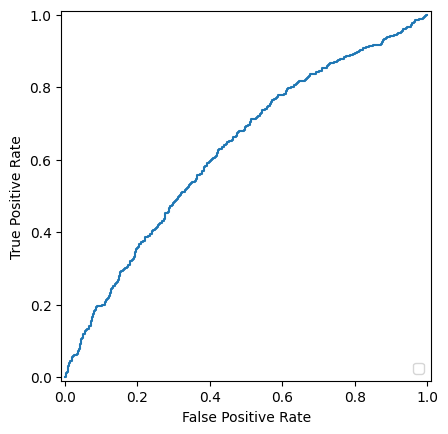

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, y_proba_auc)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

### Нейросеть

In [ ]:
def prepare_data(df):
    images = np.stack(df['image_vector'].apply(lambda x: np.array(x)).values)
    texts = np.stack(df['bert_embedding'].apply(lambda x: np.array(x)).values)

    if texts.ndim == 3 and texts.shape[1] == 1:
        texts = np.squeeze(texts, axis=1)

    labels = df['final_match'].values
    return images, texts, labels

In [ ]:
X_train_img, X_train_txt, y_train = prepare_data(train_df)
X_valid_img, X_valid_txt, y_valid = prepare_data(valid_df)

In [ ]:
def create_model():
    img_input = Input(shape=(X_train_img.shape[1],), name='image_input')
    text_input = Input(shape=(X_train_txt.shape[1],), name='text_input')

    combined = Concatenate()([img_input, text_input])

    x = Dense(512, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[img_input, text_input], outputs=output)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

In [ ]:
model = create_model()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    x=[X_train_img, X_train_txt],
    y=y_train,
    validation_data=([X_valid_img, X_valid_txt], y_valid),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9268 - auc: 0.5800 - loss: 0.2684 - val_accuracy: 0.9356 - val_auc: 0.6812 - val_loss: 0.2344
Epoch 2/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9271 - auc: 0.6786 - loss: 0.2470 - val_accuracy: 0.9356 - val_auc: 0.7031 - val_loss: 0.2227
Epoch 3/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9287 - auc: 0.7034 - loss: 0.2390 - val_accuracy: 0.9356 - val_auc: 0.7008 - val_loss: 0.2231
Epoch 4/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9301 - auc: 0.7219 - loss: 0.2320 - val_accuracy: 0.9367 - val_auc: 0.7154 - val_loss: 0.2265
Epoch 5/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9295 - auc: 0.7283 - loss: 0.2311 - val_accuracy: 0.9359 - val_auc: 0.7224 - val_loss: 0.2294
Epoch 6/100
903/903 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9315 - auc: 0.7564 - loss: 0.2214 - val_accuracy: 0.9360 - val_auc: 0.7226 - val_loss: 0.2179
Epoch 7/100
903/903 ━━━━━━━━━━━━━

In [ ]:
valid_df['pred_score'] = model.predict([X_valid_img, X_valid_txt])
fpr, tpr, _ = roc_curve(y_valid, valid_df['pred_score'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<ipython-input-211-f414c015cf17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['pred_score'] = model.predict([X_valid_img, X_valid_txt])
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


In [ ]:
best_epoch = np.argmax(history.history['val_auc'])
print(f"\nЛучшие результаты на эпохе {best_epoch + 1}:")
print(f"- Train Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"- Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"- Train AUC: {history.history['auc'][best_epoch]:.4f}")
print(f"- Validation AUC: {history.history['val_auc'][best_epoch]:.4f}")


Лучшие результаты на эпохе 22:
- Train Accuracy: 0.9412
- Validation Accuracy: 0.9365
- Train AUC: 0.9208
- Validation AUC: 0.7828


## Тестирование модели

Получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
# test_final_df.info()

In [ ]:
# test_final_df['bert_embedding'] = test_final_df['bert_embedding'].apply(
#     lambda x: np.squeeze(np.array(x)))
# test_final_df['image_vector'] = test_final_df['image_vector'].apply(
#     lambda x: np.array(x))


In [ ]:
# def predict_matches(model, text_vectors, image_vectors):
#     batch_size = 32
#     predictions = []

#     for i in range(0, len(text_vectors), batch_size):
#         text_batch = np.stack(text_vectors[i:i+batch_size])
#         image_batch = np.stack(image_vectors[i:i+batch_size])

#         batch_pred = model.predict([image_batch, text_batch], verbose=0)
#         predictions.extend(batch_pred.flatten())

#     return np.array(predictions)

In [ ]:
# pred_probs = predict_matches(model,
#                            test_final_df['bert_embedding'].tolist(),
#                            test_final_df['image_vector'].tolist())

In [ ]:
# test_final_df['pred_match'] = (pred_probs >= 0.5).astype(int)
# test_final_df['pred_prob'] = pred_probs

In [ ]:
# test_final_df[['query_text', 'image', 'pred_match', 'pred_prob']].head()

In [ ]:
# matched_df = test_final_df[test_final_df['pred_match'] == 1]
# sampled_matches = matched_df.sample(10, random_state=42)

In [ ]:
# fig = plt.figure(figsize=(12, 3 * len(sampled_matches)))
# plt.subplots_adjust(hspace=0.4)

# for i, (_, row) in enumerate(sampled_matches.iterrows(), 1):
#     img_path = os.path.join(test_images_path, row['image'])
#     img = Image.open(img_path)

#     ax = plt.subplot(len(sampled_matches), 2, 2*i-1)

#     ax.imshow(img)
#     ax.axis('off')

#     wrapped_text = textwrap.fill(row['query_text'], width=60)

#     ax_text = plt.subplot(len(sampled_matches), 2, 2*i)
#     ax_text.text(0, 0.5,
#                f"\n{wrapped_text}\n\nPrediction probability: {row['pred_prob']:.2f}",
#                fontsize=10,
#                verticalalignment='center')
#     ax_text.axis('off')

# plt.tight_layout()
# plt.show()

In [ ]:
def show_result(query_text: str, image_path: str, probability: float,
               child_keywords: List[str] = child_keywords):
    if any(keyword.lower() in query_text.lower() for keyword in child_keywords):
        plt.figure(figsize=(10, 4))
        plt.text(0.5, 0.5,
                "This image is unavailable in your country\nin compliance with local laws",
                ha='center', va='center', fontsize=12, wrap=True)
        plt.axis('off')
        plt.show()
    else:
        try:
            plt.figure(figsize=(8, 6))
            img = plt.imread(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Запрос: {query_text}\nВероятность: {probability:.4f}", wrap=True)
            plt.show()
        except Exception as e:
            print(f"Ошибка загрузки изображения: {str(e)}")
            print(f"Путь: {image_path}")

def process_multiple_queries(
    test_queries_df: pd.DataFrame,
    test_image_df: pd.DataFrame,
    bert_model: Any,
    tokenizer: Any,
    model: Any,
    test_images_path: str,
    n_queries: int = 10,
    child_keywords: List[str] = child_keywords
) -> List[Tuple[str, str, float]]:
    results = []

    for i in range(n_queries):
        try:
            random_query = test_queries_df.sample(1)['query_text'].values[0]

            text_vector = get_bert_embeddings(random_query, bert_model, tokenizer)

            temp_df = test_image_df.copy()
            temp_df['bert_embedding'] = [text_vector] * len(temp_df)
            temp_df['bert_embedding'] = temp_df['bert_embedding'].apply(
                lambda x: np.squeeze(np.array(x)))
            temp_df['image_vector'] = temp_df['image_vector'].apply(
                lambda x: np.array(x))

            pred_probs = model.predict(
                [np.stack(temp_df['image_vector'].values),
                 np.stack(temp_df['bert_embedding'].values)],
                verbose=0
            ).flatten()

            temp_df['pred_prob'] = pred_probs
            best_match = temp_df.loc[temp_df['pred_prob'].idxmax()]

            img_path = os.path.join(test_images_path, best_match['image'])
            results.append((random_query, img_path, best_match['pred_prob']))

        except Exception as e:
            print(f"Ошибка при обработке запроса {i+1}: {str(e)}")
            continue

    return results


1. Результат:


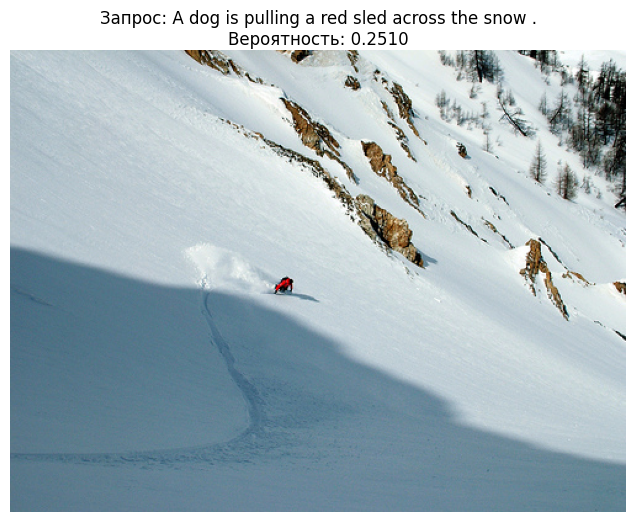


2. Результат:


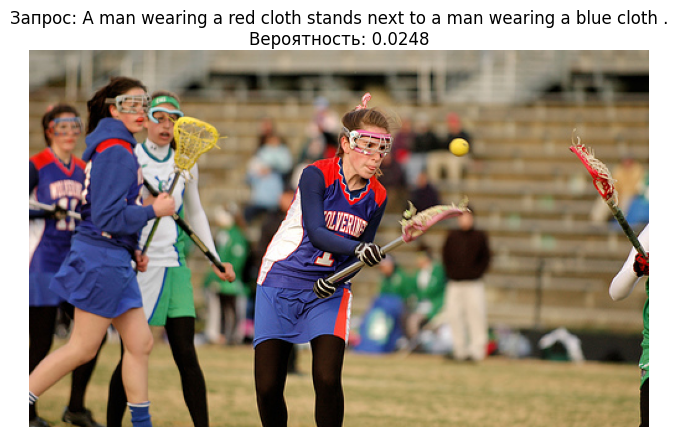


3. Результат:



4. Результат:



5. Результат:


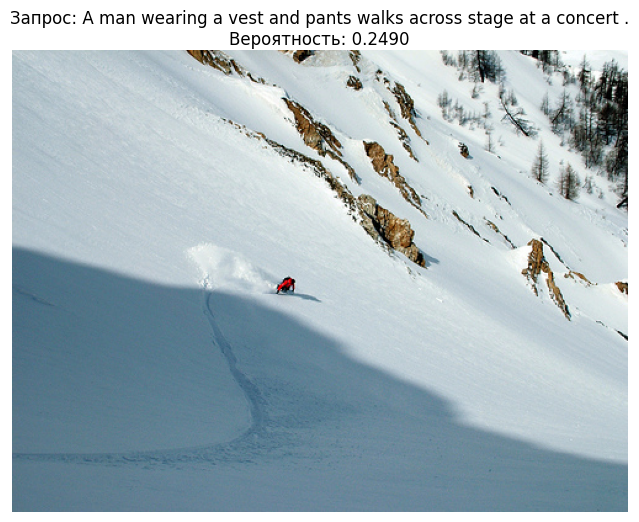


6. Результат:


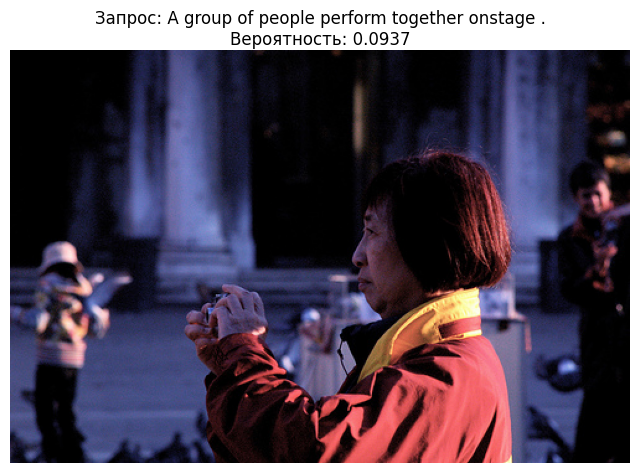


7. Результат:


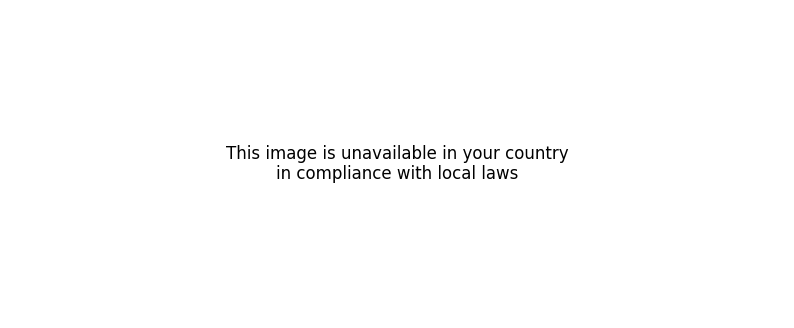


8. Результат:


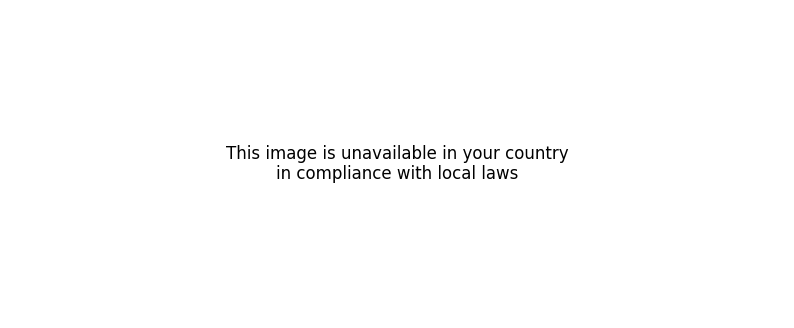


9. Результат:


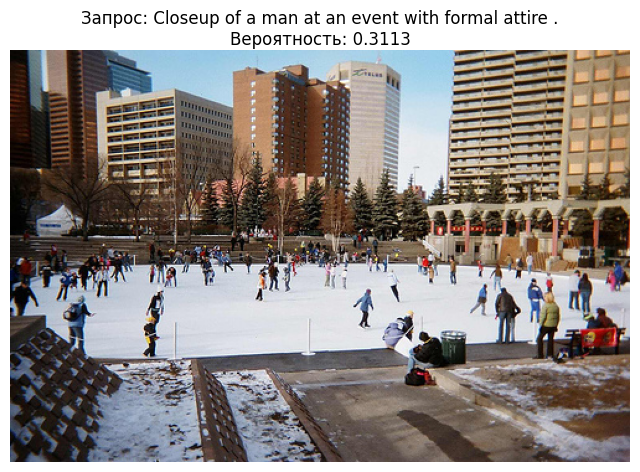


10. Результат:


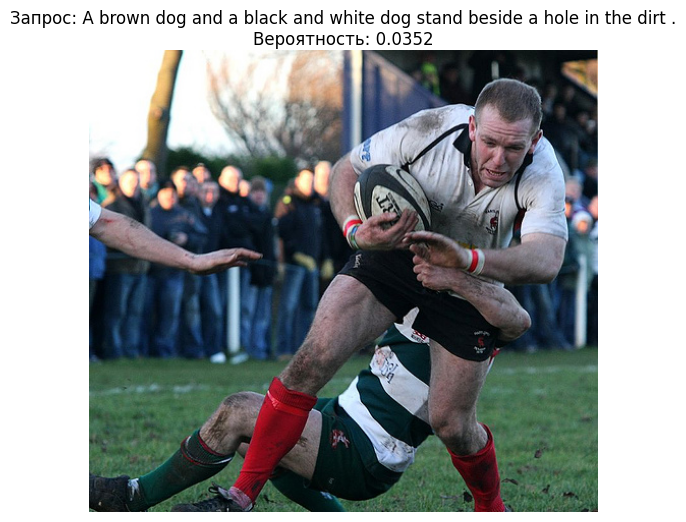

In [ ]:
if __name__ == "__main__":
    test_images_path = "/content/drive/MyDrive/Colab Notebooks/Yandex_DS/Project_search_by_pic/test_images"
    n_queries = 10
    query_results = process_multiple_queries(
        test_queries_df,
        test_image_df,
        bert_model,
        tokenizer,
        model,
        test_images_path,
        n_queries
    )

    for i, (query, img_path, prob) in enumerate(query_results, 1):
        print(f"\n{i}. Результат:")

        show_result(query, img_path, prob)